# Лабораторная работа 1. Введение в PyTorch

### Содержание
1. [Установка](#Установка)
1. [Тензоры](#Тензоры)
1. [Автоматическое дифференцирование](#Автоматическое-дифференцирование)
1. [Линейная регрессия в PyTorch](#Линейная-регрессия-в-PyTorch)
1. [Линейная классификация в PyTorch](#Линейная-классификация-в-PyTorch)

### Установка
Чтобы установить PyTorch, нужно на [официальном сайте](https://pytorch.org/get-started/locally/) сгенерировать команду для установки в зависимости от версии операционной системы и других параметров.  
Рекомендуется также установить [CUDA](https://developer.nvidia.com/cuda-zone) (Compute Unified Device Architecture) – вычислительную платформу от Nvidia для поддержки вычислений на видеокартах и [CuDNN](https://developer.nvidia.com/cudnn) (CUDA Deep Neural Network) – библиотеку на основе CUDA для поддержки глубоких нейронных сетей.  
Проверить правильность установки и узнать версии используемого ПО можно следующим образом:

In [1]:
import torch
import sys

In [2]:
# Утилита от Nvidia для вывода информации о видеокарте
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [3]:
print('Python VERSION:', sys.version)
print('\npyTorch VERSION:', torch.__version__)
print('\nCUDA VERSION:')
! nvcc --version
print('\nCUDNN VERSION:', torch.backends.cudnn.version())
print('\nNumber CUDA Devices:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())
print('Cuda device name: ', torch.cuda.get_device_name(0))

Python VERSION: 3.13.2 (main, Feb  5 2025, 08:05:21) [GCC 14.2.1 20250128]

pyTorch VERSION: 2.6.0+cu124

CUDA VERSION:
zsh:1: command not found: nvcc

CUDNN VERSION: 90100

Number CUDA Devices: 0


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

---
Проверить доступность CUDA можно также следующим образом:

In [5]:
torch.cuda.is_available()

False

### Тензоры
*Тензор* – многомерный массив данных в библиотеках глубокого обучения. Тензор может быть 0-мерным (скаляр), одномерным (вектор), двумерным (матрица) или размерностью больше двух.  
Тензоры используются для представления входов, выходов и параметров моделей.

#### Инициализация тензоров
Тензоры могут быть инициализированы несколькими способами.

1. На основе данных:

In [6]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
x_data

tensor([[1, 2],
        [3, 4]])

2. Из массивов NumPy:

In [7]:
import numpy as np
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
x_np

tensor([[1, 2],
        [3, 4]])

3. Заполненные случайным образом или константными значениями:

In [8]:
shape = (2,3)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f'Random Tensor: \n {rand_tensor} \n')
print(f'Ones Tensor: \n {ones_tensor} \n')
print(f'Zeros Tensor: \n {zeros_tensor}')

Random Tensor: 
 tensor([[0.1093, 0.0713, 0.3934],
        [0.3326, 0.3399, 0.4449]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


#### Атрибуты тензоров
Тензоры имеют несколько атрибутов, в том числе:

In [9]:
tensor = torch.rand(3, 4)
print(f'Shape of tensor: {tensor.shape}')
print(f'Datatype of tensor: {tensor.dtype}')
print(f'Device tensor is stored on the following device: {tensor.device}')

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on the following device: cpu


#### Операции над тензорами
По умолчанию тензоры создаются на CPU.  
Чтобы переместить их на GPU нужно вызвать метод `to`:

In [10]:
print(f'Tensor is stored on: {tensor.device}')
if torch.cuda.is_available():
    tensor = tensor.to('cuda')
print(f'Tensor is stored on: {tensor.device}')

Tensor is stored on: cpu
Tensor is stored on: cpu


---
Индексирование и срезы (slicing):

In [11]:
tensor = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
print(f'Initial tensor:\n{tensor}\n')
print(f'First row: {tensor[0]}\n')
print(f'Second row: {tensor[1]}\n')
print(f'Last row: {tensor[-1]}\n')
print(f'First column: {tensor[:, 0]}\n')
print(f'Second column: {tensor[:, 1]}\n')
print(f'Next-to-last column: {tensor[:, -2]}\n')
print(f'Last column: {tensor[..., -1]}\n')
tensor[:,1] = 0
print(tensor)

Initial tensor:
tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])

First row: tensor([1, 2, 3, 4])

Second row: tensor([5, 6, 7, 8])

Last row: tensor([ 9, 10, 11, 12])

First column: tensor([1, 5, 9])

Second column: tensor([ 2,  6, 10])

Next-to-last column: tensor([ 3,  7, 11])

Last column: tensor([ 4,  8, 12])

tensor([[ 1,  0,  3,  4],
        [ 5,  0,  7,  8],
        [ 9,  0, 11, 12]])


---
Конкатенация:

In [12]:
concat_tensor = torch.cat([tensor, tensor, tensor], dim=1)
print(concat_tensor)

tensor([[ 1,  0,  3,  4,  1,  0,  3,  4,  1,  0,  3,  4],
        [ 5,  0,  7,  8,  5,  0,  7,  8,  5,  0,  7,  8],
        [ 9,  0, 11, 12,  9,  0, 11, 12,  9,  0, 11, 12]])


---
Арифметические операции:

In [13]:
shape = (3, 3)
tensor1 = torch.ones(shape)
tensor2 = torch.ones(shape)
tensor_sum = tensor1 + tensor2
print(f'tensor1 + tensor2 = \n{tensor_sum}\n')
tensor_mul1 = tensor1 @ tensor2
print(f'tensor1 @ tensor2 = \n{tensor_mul1}\n')
tensor_mul2 = torch.matmul(tensor1, tensor2)
print(f'torch.matmul(tensor1, tensor2) = \n{tensor_mul2}\n')
tensor_mul3 = tensor1 * tensor2
print(f'tensor1 * tensor2 = \n{tensor_mul3}\n')

tensor1 + tensor2 = 
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])

tensor1 @ tensor2 = 
tensor([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]])

torch.matmul(tensor1, tensor2) = 
tensor([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]])

tensor1 * tensor2 = 
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])



---
Тензор может состоять из одного элемента (скаляр). В этом случае для доступа к значению тензора можно воспользоваться методом `item`:

In [14]:
summa = tensor.sum()
print(f'summa = {summa}, type(summa): {type(summa)}\n')
print(f'summa.item() = {summa.item()}, type(summa.item()): {type(summa.item())}')

summa = 60, type(summa): <class 'torch.Tensor'>

summa.item() = 60, type(summa.item()): <class 'int'>


---
Операции `in-place` – это операции, результат которых сохраняется в самом операнде. Обозначаются суфиксом `_`:

In [15]:
print(f'{tensor}\n')
tensor.add_(5)
print(tensor)

tensor([[ 1,  0,  3,  4],
        [ 5,  0,  7,  8],
        [ 9,  0, 11, 12]])

tensor([[ 6,  5,  8,  9],
        [10,  5, 12, 13],
        [14,  5, 16, 17]])


### Автоматическое дифференцирование

Для настройки весов в нейронных сетях используется *алгоритм обратного распространения ошибки* (back propagation). В этом алгоритме веса изменяются в зависимости от градиента функции ошибки.  
В PyTorch модуль `torch.autograd` отвечает за автоматическое дифференцирование на вычислительном графе.  

Рассмотрим сигмоидальную функцию и её производную:
$$\sigma(u)=\frac{1}{1+e^{-u}}$$
  
$$\sigma'(u)=\frac{e^{-u}}{(1+e^{-u})^2}=\frac{1}{(1+e^{-u})}\frac{e^{-u}}{(1+e^{-u})}=\frac{1}{(1+e^{-u})}\frac{(1+e^{-u})-1}{(1+e^{-u})}=\sigma(u)(1-\sigma(u))$$

Зададим эти функции в PyTorch и нарисуем их графики:

In [16]:
def sigmoid(u):
    return 1 / (1 + torch.exp(-u))

In [17]:
def sigmoid_deriv(u):
    return sigmoid(u) * (1 - sigmoid(u))

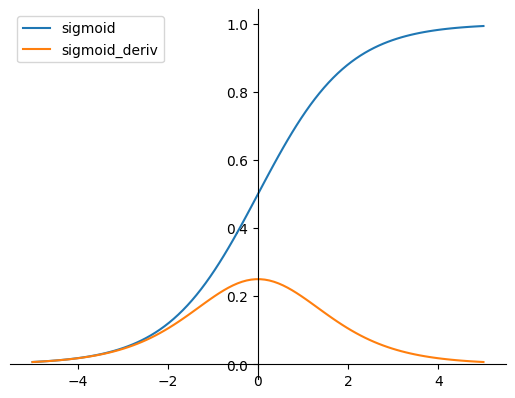

In [18]:
import matplotlib.pyplot as plt
x = torch.tensor(np.linspace(-5, 5, 100))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position(('data', 0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, sigmoid_deriv(x), label='sigmoid_deriv')
ax.legend()
plt.show()

Зададим тензор, для которого мы хотели бы найти градиент (параметр `requires_grad=True`):

In [19]:
u = torch.tensor(0.0, requires_grad=True)
u

tensor(0., requires_grad=True)

Зададим тензор, которому присвоим значение функции 

In [20]:
s = sigmoid(u)
s

tensor(0.5000, grad_fn=<MulBackward0>)

В атрибуте `grad_fn` хранится ссылка на функцию, которая была использована для вычисления тензора.  
В случае задания тензора пользователем – `grad_fn = None`:

In [21]:
print(f'u.grad_fn: {u.grad_fn}\n')
print(f's.grad_fn: {s.grad_fn}\n')
a = u + u
print(f'(u+u).grad_fn: {a.grad_fn}\n')
a = u - u
print(f'(u-u).grad_fn: {a.grad_fn}\n')
a = u * u
print(f'(u*u).grad_fn: {a.grad_fn}\n')
a = u / u
print(f'(u/u).grad_fn: {a.grad_fn}\n')
a = 1 / u
print(f'(1/u).grad_fn: {a.grad_fn}\n')
a = torch.mean(u)
print(f'mean(u).grad_fn: {a.grad_fn}')

u.grad_fn: None

s.grad_fn: <MulBackward0 object at 0x7df8b92b5330>

(u+u).grad_fn: <AddBackward0 object at 0x7df8b92b5fc0>

(u-u).grad_fn: <SubBackward0 object at 0x7df8b92bc640>

(u*u).grad_fn: <MulBackward0 object at 0x7df8a21924d0>

(u/u).grad_fn: <DivBackward0 object at 0x7df8a21924d0>

(1/u).grad_fn: <MulBackward0 object at 0x7df8a21924d0>

mean(u).grad_fn: <MeanBackward0 object at 0x7df8a21924d0>


---
Для вычисления градиента необходимо вызвать метод `backward`:

In [22]:
s.backward()

Значение градиента после вызова `backward` хранится в атрибуте `grad`:

In [23]:
u.grad

tensor(0.2500)

Проверим, что значение градиента (производной) совпадает со значением, вычисленным аналитически:

In [24]:
sigmoid_deriv(u)

tensor(0.2500, grad_fn=<MulBackward0>)

Обратите внимание, что повторный вызов метода `backward` невозможен:

In [26]:
# Раскомментируйте эту строку
# s.backward()

Для того, чтобы повторно вызывать метод `backward`, следует указать при его вызове параметр `retain_graph=True`. Но имейте в виду, что в этом случае значение градиента будет накапливаться:

In [27]:
a = torch.tensor(1.0, requires_grad=True)
b = a * a
b.backward(retain_graph=True)
print(f'a.grad = {a.grad}')
b.backward(retain_graph=True)
print(f'a.grad = {a.grad}')
b.backward()
print(f'a.grad = {a.grad}')

a.grad = 2.0
a.grad = 4.0
a.grad = 6.0


При необходимости градиенты можно обнулить:

In [28]:
u.grad.data.zero_()
u.grad

tensor(0.)

#### Задание 1

**1.1** Проверьте значения производной сигмоидальной функции, вычисленные в разных точках. Сравните их со значениями на графике функций.

*Примечание:*
Отметим, что в PyTorch, конечно, имеется [своя реализация](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) сигмоидальной функции.

**1.2**. Посчитайте значения градиента при помощи сигмоидальной функции из PyTorch.

*Замечание*. Мы можем найти градиенты только для листьев в графе вычислений.

#### Приостановка отслеживания градиентов
По умолчанию, PyTorch отслеживает историю вычислений и поддерживает вычисление градиентов для тензоров, у которых установлено `requires_grad=True`.  
Однако иногда бывает необходимо приостановить отслеживание, например, когда сеть уже обучена и требуется выполнять только прямой проход или когда в процессе обучения сети нужно зафиксировать веса определенных слоев. В этом случае можно воспользоваться блоком `no_grad` или методом `detach()`:

In [ ]:
s = sigmoid(u)
print(f's.requires_grad = {s.requires_grad}')

with torch.no_grad():
    s = sigmoid(u)
print(f's.requires_grad = {s.requires_grad}')

In [ ]:
s = sigmoid(u)
print(f's.requires_grad = {s.requires_grad}')

s = s.detach()
print(f's.requires_grad = {s.requires_grad}')

### Линейная регрессия в PyTorch

#### Создание модели
Построим однослойную сеть, состоящую из одного нейрона, которая аналогична обычной линейной регрессии.

Пространство имен `nn` в PyTorch предоставляет все необходимые блоки для построения нейронных сетей.  
Каждый модуль наследует классу [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Нейронная сеть представляет собой также модуль, который содержит другие модули (слои).

In [ ]:
from torch import nn

Определим устройство, на котором будем обучать сеть:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using "{}" device'.format(device))

Опишем класс нашей нейронной сети (который должен являться наследником `nn.Module`):

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.regr = nn.Linear(1, 1)

    def forward(self, x):
        y = self.regr(x)
        return y

Метод `__init__` является конструктором класса.  
В первой строке конструктора вызывается конструктор базового класса `nn.Module`.  
Во второй строке создается единственный слой, содержащий один нейрон, с помощью модуля [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).  
Данный модуль осуществляет линейное преобразование входа $\vec{x}$ в выход $\vec{y}$ с учетом матрицы весов $W$:  

$$\vec{y}=\vec{x}W^T+\vec{b}.$$

Первый аргумент для `Linear` – `in_features` – количество входов $x$, второй `out_features` – количество выходов $y$ (фактически, количество нейронов в данном слое). Существует также третий аргумент – `bias`, определяющий наличие вектора свободных коэффициентов $\vec{b}$ (по умолчанию `bias=True`).  
Матрица весов $W$ будет иметь размерность (`out_features`, `in_features`), вектор свободных коэффициентов $\vec{b}$ – (`out_features`).  
Значения $W$ и $\vec{b}$ инициализируются случайным образом из равномерного распределения $U(-\sqrt{k},\sqrt{k})$, где $k=\frac{1}{in\_features}$.

Заметим, что атрибут `requires_grad` для тензоров-весов сети автоматически устанавливается в `True`.

Метод `forward` определяет поток данных через нашу сеть (*прямой проход*). Аргумент `x` – это входные данные для сети. В нашем примере к `x` применяется линейное преобразование, результат которого является выходом сети (линейная регрессия).

---
Инициализируем генератор случайных чисел PyTorch для воспроизводимости результатов (для одинаковых начальных значений весов):

In [ ]:
torch.manual_seed(42)

Создаем экземпляр класса `NeuralNetwork` и выводим структуру сети:

In [ ]:
model = NeuralNetwork()
model

---
Перемещаем сеть на GPU:

In [ ]:
model.to(device)

---
Вывод значений весов:

In [ ]:
def print_weights(model):
    
    for parameter in model.named_parameters():
        print(f'{parameter[0]} = {parameter[1].data}')

In [ ]:
print_weights(model)

#### Генерация набора данных

Инициализируем генератор случайных чисел `numpy` для воспроизводимости результатов:

In [ ]:
np.random.seed(42)

Генерируем случайные данные:  
- $X$ – из равномерного распределения от 1 до 10,
- $y=2x+1$ с учетом нормально распределенного шума.

In [ ]:
n_samples = 100
data = np.random.uniform(1, 10, (n_samples, 1)).astype(np.float32)
targets = 2 * data + 1 + np.random.normal(0, 2, (n_samples, 1)).astype(np.float32)

In [ ]:
plt.scatter(data, targets)
plt.show()

Создаем тензоры PyTorch:

In [ ]:
data = torch.from_numpy(data)
targets = torch.from_numpy(targets)

Перемещаем тензоры на GPU:

In [ ]:
data = data.to(device)
targets = targets.to(device)

Нарисуем предсказание модели со случайно инициализированными весами:

In [ ]:
predictions = model(data)
plt.scatter(data.cpu().numpy(), targets.cpu().numpy())
plt.plot(data.cpu().detach().numpy(), predictions.cpu().detach().numpy())
plt.show()

#### Обучение сети
Сначала задаем функцию потерь ([MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)):

In [ ]:
loss_fn = nn.MSELoss()

Затем определим оптимизатор:

In [ ]:
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer

Зададим функцию, определяющую действия в процессе одной эпохи обучения:

In [ ]:
def train_loop(data, targets, model, loss_fn, optimizer):
    
    # Устанавливаем для модели режим обучения: эквивалентно model.training = True
    # Действует только на модули Dropout, BatchNorm, InstanceNorm (https://stackoverflow.com/questions/66534762/which-pytorch-modules-are-affected-by-model-eval-and-model-train)
    model.train()
    
    for i in range(len(data)):
        # Вычисляем предсказание модели на одном объекте
        pred = model(data[i])
        
        # Вычисляем функцию потерь
        loss = loss_fn(pred, targets[i])

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print(f'loss: {loss}')

Запускаем цикл обучения:

In [ ]:
epochs = 10
print_weights(model)
for t in range(epochs):
    print(f'-------------------------------\nEpoch {t+1}')
    train_loop(data, targets, model, loss_fn, optimizer)
    print()
    print_weights(model)

---
Нарисуем получившуюся модель:

In [ ]:
# Возвращаем модель в режим инференса:  эквивалентно model.training = False
model.eval()

predictions = model(data)
plt.scatter(data.cpu().numpy(), targets.cpu().numpy())
plt.plot(data.cpu().detach().numpy(), predictions.cpu().detach().numpy())

#### Задание 2

**2.1**. Вычислите MSE для итоговой модели.

**2.2**. Выполните перебор гиперпараметров – скорости обучения и количества эпох (не менее пяти значений на каждый гиперпараметр) и найдите комбинацию, при которой достигается минимум MSE на обучающих данных.

### Линейная классификация в PyTorch

#### Генерация набора данных
Сгенерируем набор данных для классификации: объекты с меткой "0" будут нормально распределены вокруг точки (-1, -1),  объекты с меткой "1" – вокруг точки (1, 1):

In [ ]:
n_samples = 100
half = int(n_samples / 2)
     
x_class0 = np.random.normal(size=[half, 2]) + [-1, -1]
y_class0 = np.zeros((half, 1))

x_class1 = np.random.normal(size=[half, 2]) + [1, 1]
y_class1 = np.ones((half, 1))

data = np.vstack([x_class0, x_class1])
targets = np.vstack([y_class0, y_class1])

In [ ]:
data = data.astype(np.float32)
targets = targets.astype(np.float32)

In [ ]:
plt.scatter(x_class0[:, 0], x_class0[:, 1], c='red')
plt.scatter(x_class1[:, 0], x_class1[:, 1], c='blue')

#### Задание 3

**3.1** Постройте нейронную сеть – линейный классификатор, разбейте набор данных на обучающую и валидацинную подвыборки. Визуализируйте полученные подвыборки данных. Обучите модель распознавать приведенный набор данных.

*Подсказка*: в качестве функции потерь можно использовать Binary Cross Entropy ([BCELOSS](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).

**3.2** Исследуйте значение функции потерь на обучающей и валидационной подвыборках после 1, 5, 10, 50, 100, 200, 500, 1000 эпох. Визуализируйте результаты. Достигается ли переобучение после какой-либо из эпох?

**3.3** Сгенерируйте новые наборы данных при `n_samples` равном 100, 500, 1000. Проанализируйте качество обучения при разном объёме сгнерированных данных. Постройте график `loss` (на валидационной выборке) -`n_samples`.

#### Задание 4 (факультативное)
Прочитать параграф 2.6 в учебнике С. Николенко и др. (стр. 81–92) и воспроизвести рассмотренные там нейронные сети на TensorFlow и Keras.